## Signal vs. Resolution (Figure 10)

In [1]:
# Import modules
import sys, h5py
import numpy as np
import scipy.ndimage as ndimage
import spimage
%matplotlib inline

# Import modules from src directory
sys.path.append("../src")
import plotting

In [2]:
# Configuration (Experiment)
distance_back  = 2.4 #[m]
distance_front = 0.497 #[m]
pixelsize = 110e-6 #[m]
wavelength = 0.2262e-9 #[m]
scaling = (distance_back/distance_front)**2

# Cropping of front detector
c  = 700   

### 1. Loading data from file

In [3]:
filename_signal = "../meta/single-shot_assembled.h5"
filename_back  = "../meta/single-shot_back.h5"
filename_front = "../meta/single-shot_front.h5"
filename_background_buffer =  "../meta/background_buffer_stats.h5"
filename_mask_front_poisson = "../meta/front/masks/front_mask_poisson.h5"

In [4]:
# Loading the signal (assembled)
with h5py.File(filename_signal, 'r') as f:
    signal_data = np.rot90(f['data/data'][:], k=2)                                                                                                                               
    signal_mask = ~np.rot90(f['data/mask'][:].astype(np.bool), k=2)  
    signal_diameter = f['diameter'][...]
    signal_intensity = f['intensity'][...]
    signal_id = f['id'][...]
print "Loaded signal with ID (%s), diameter (%.2f nm) and intensity (%.2f mJ/um2)" %(signal_id, signal_diameter, signal_intensity)

Loaded signal with ID (LCLS_2014_Apr14_r0182_201014_168e4), diameter (43.24 nm) and intensity (0.76 mJ/um2)


In [5]:
# Loading the signal (back)
with h5py.File(filename_back, 'r') as f:
    signal_back  = f['data']['data'][:]
    signal_bmask = f['data']['mask'][:].astype(np.bool)

In [6]:
# Loading the signal (front)
with h5py.File(filename_front, 'r') as f:
    signal_front  = np.rot90(f['data']['data'][:], k=2).astype(np.float)

In [7]:
# Loading the background (buffer)
with h5py.File(filename_background_buffer, 'r') as f:
    buffer_back_mean  = f['back/mean'][:]
    buffer_back_std   = f['back/std'][:]
    buffer_front_mean = np.rot90(f['front/mean'][:], k=2)
    buffer_front_std  = np.rot90(f['front/std'][:], k=2)
    nframes    = f['nframes'][...]
print "Loaded buffer background from %d frames" %nframes

Loaded buffer background from 11847 frames


In [8]:
with h5py.File(filename_mask_front_poisson, 'r') as f:
    fmask = f['data/data'][:].astype(np.bool)

### 2. Radial average

In [9]:
# Center of front detector
cx_back=(buffer_back_mean.shape[1]-1)/2.0-16
cy_back=(buffer_back_mean.shape[0]-1)/2.0-36

# Center of front detector
cx_front=(buffer_front_mean.shape[1]-1)/2.0-3
cy_front=(buffer_front_mean.shape[0]-1)/2.0-20

In [10]:
# Convert index to q (in nm)
x_to_q = lambda x, d, p: (2*np.sin(np.arctan2(x*p, d)/2.)) / wavelength / 1e9
# Convert q to index (in nm)
q_to_x = lambda q, d: np.tan(2.*np.arcsin(wavelength * 1e9 * q / 2.)) * d / pixelsize

In [11]:
# Radial average of signal (back)
back_centers, back_radial = spimage.radialMeanImage(signal_back, msk=signal_bmask, cx=cx_back, cy=cy_back, output_r=True)
back_radial *= (distance_back/distance_front)**2
back_qr = x_to_q(back_centers, distance_back, pixelsize)

# Radial average of signal (front)
front_centers, front_radial = spimage.radialMeanImage(signal_front, msk=fmask, cx=cx_front, cy=cy_front, output_r=True)
front_qr = x_to_q(front_centers, distance_front, pixelsize)

In [12]:
# Radial average of buffer background (back)
buffer_back_centers, buffer_back_mean_radial = spimage.radialMeanImage(buffer_back_mean, msk=signal_bmask, output_r=True)
buffer_back_mean_radial *= (distance_back/distance_front)**2
buffer_back_qr = x_to_q(buffer_back_centers, distance_back, pixelsize)

# Radial average of buffer background (front)
buffer_front_centers, buffer_front_mean_radial = spimage.radialMeanImage(buffer_front_mean, msk=fmask, cx=cx_front,cy=cy_front, output_r=True)
buffer_front_qr = x_to_q(buffer_front_centers, distance_front, pixelsize)

### 3. Sphere diffraction model

In [13]:
# Model parameters
diameter = signal_diameter * 1e-9
intensity = signal_intensity*1e-3*1e12

In [14]:
s   = spimage.sphere_model_convert_diameter_to_size(diameter, wavelength, pixelsize, distance_front)
A   = spimage.sphere_model_convert_intensity_to_scaling(intensity, diameter, wavelength, pixelsize, distance_front, detector_qe=1.0, detector_adu_photon=1.0, material="virus")
q   = spimage.x_to_qx(np.arange(0,2000), pixelsize, distance_front)
xfit = x_to_q(np.arange(0,2000), distance_front, pixelsize)
yfit = spimage.I_sphere_diffraction(A, q, s)

### 4. Plotting

In [15]:
xbg3 = buffer_back_qr
#ybg3 = ndimage.median_filter(buffer_back_mean_radial,10)
ybg3 = ndimage.gaussian_filter1d(buffer_back_mean_radial,1)

xbg4 = buffer_front_qr
#ybg4 = ndimage.median_filter(buffer_front_mean_radial,10)
ybg4 = ndimage.gaussian_filter1d(buffer_front_mean_radial,2)

# Signal
ysignal = np.hstack([back_radial, front_radial])
xsignal = np.hstack([back_qr, front_qr])
sigsorted = np.argsort(xsignal)
xsignal = xsignal[sigsorted]
ysignal = ysignal[sigsorted]
#ysignal = ndimage.median_filter(ysignal,4)
ysignal = ndimage.gaussian_filter1d(ysignal,2)

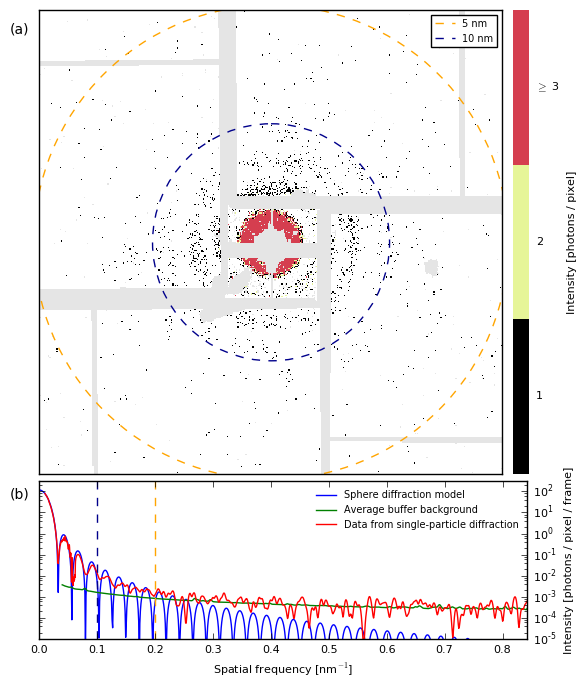

In [16]:
plot = plotting.Plot(fontsize=8, rows=4, cols=3, exclude=range(12), aspect=1, 
                     colorbar=False, legend=True, legend_frameon=False, save_pdf=True)
plot.add_axes((0,1),3,3, hfrac=0.95, padx=-0.02, pady=0.01)
plot.add_axes((2,1),1,3, hfrac=0.95, wfrac=0.1, padx=0.7, pady=0.01)
plot.add_axes((0,0),3,1)

plot.title_label = 5*['']
plot.xlabel = 2*[''] + [r'Spatial frequency [nm$^{-1}$]'] + 2*['']
plot.ylabel = 2*[''] + [r'Intensity [photons / pixel / frame]'] + 2*['']
plot.colorbar_label = r'Intensity [photons / pixel]'

# Plotting assembled diffraction pattern
plot.axes[0] = plot.set_axes_layout(plot.axes[0], visible=False)
plot.plotting_a_map(0, (signal_data)[c-48:-c+6,c-34:-c+20], 
                    mask=signal_mask[c-48:-c+6,c-34:-c+20], 
                    cmap='discrete', vmin=1, vmax=4, log=False, 
                    discrete_colors=3, under='w', bad='0.9', colorbar=True, cax=plot.axes[1])
plot.cb.ax.tick_params(length=0, width=0)
plot.cb.set_ticks([1.5,2.5,3.5])
plot.cb.set_ticklabels(['1', '2', '$\mathbf{\geq}$ 3'])
plot.cb.outline.set_visible(False)
plot.plotting_a_circle(0, q_to_x(1./5., distance_front), 200,200, 
                       color='orange', linestyle='dashed', width=1, label='5 nm')
plot.plotting_a_circle(0, q_to_x(1./10., distance_front), 200,200, 
                       color='darkblue', linestyle='dashed', width=1, label='10 nm')
plot.axes[0].text(-25, 10, '(a)', va='top', ha='left', fontsize=10)

# Legend for resolution rings
import matplotlib.lines as mlines
orange_line   = mlines.Line2D([], [], color='orange',   marker=None, lw=1, linestyle='dashed', label='5 nm')
darkblue_line = mlines.Line2D([], [], color='darkblue', marker=None, lw=1, linestyle='dashed', label='10 nm')
lines  = [orange_line, darkblue_line]
labels = [line.get_label() for line in lines]
plot.axes[0].legend(lines, labels, prop={'size':plot.fontsize-1}, loc=1, numpoints=1, markerscale=2, frameon=True)

# Plotting radial averages
plot.plotting_traces(2,                                                                                                                                                            
                     [xfit, xbg3, xbg4, xsignal],                                                               
                     [yfit, ybg3, ybg4, ysignal],                                          
                     [r'Sphere diffraction model', None, 'Average buffer background', 'Data from single-particle diffraction'],                                 
                     linestyles=['-', '-', '-', '-'],                                                                                                           
                     linewidths=[1,0,1,1], xlim=[0,x_to_q(1746/2., distance_front, pixelsize)], ylim=[1e-5,300],                                                                                                    
                     markersize=2, markers=['None', 'None', 'None', 'None',],                                                                                                 
                     mecs=['b', 'g', 'g', 'r'], mfcs=['b', 'g', 'g', 'r'],                                                                            
                     colors=['b', 'g', 'g', 'r'], alphas=[1,1,1,1,1],                                                                                                  
                     logx=False, logy=True)

#plot.axes[2].axvline(x_to_q(200., distance_front, pixelsize), color='k', ls='-')
plot.axes[2].axvline(1/(5.), color='orange', ls='--')
plot.axes[2].axvline(1/(10.), color='darkblue', ls='--')
plot.axes[2].text(-0.05, 150, '(b)', va='top', ha='left', fontsize=10)
plot.axes[2].yaxis.set_label_position('right')
plot.axes[2].tick_params(labelleft='off', labelright='on')
# Save plot
#plot.save('/Users/benedikt/phd-project/documentation/manuscripts/omrv-paper/manuscript/figures/fig_signal_vs_noise.pdf')
plot.show()

**Figure 10.**
Comparison of signal from a strong single-shot diffraction pattern and average buffer background.                                                                         
(a) Assembled diffraction pattern from a single shot with estimated particles size of $43.2$~nm and incident photon intensity of $8.65\cdot 10^{11}$ photons / $\mu$m$^2$.         
Masked areas (no photons detected, bad pixels, strong X-ray background) are colored in gray.                                                                                       
Dashed rings indicate areas with full-period resolution of $5$ and $10$ nm.                                                                                                        
(b) Radial averages of the single-shot diffraction (red), the average buffer background (green) and the sphere diffraction model (blue).                                           
A gaussian filter with a kernel sigma of 1 pixel is applied to both traces from experimental data (red and green).                                                                 
The black solid line marks the edge of the cropped diffraction pattern shown in (a).